<a href="https://colab.research.google.com/github/MathewNhari/Climate-Change-Belief-Analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from imblearn.over_sampling import SMOTE
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC 

from sklearn.model_selection import GridSearchCV

from sklearn.utils import resample

In [3]:
nlp = spacy.load("en_core_web_sm")
pd.read_csv('sample_submission.csv').head()

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,1


In [4]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


In [6]:
X = train_df['message']
y = train_df['sentiment']

In [7]:
anti = train_df[y==-1]
neutral = train_df[y==0]
pro = train_df[y==1]
news = train_df[y==2]

y.value_counts()

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

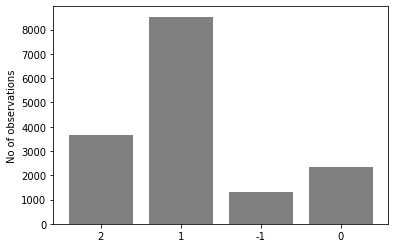

In [8]:
labels = y.unique()
heights = [len(anti),len(neutral),len(pro),len(news)]
plt.bar(labels,heights,color='grey')
plt.xticks(labels,['-1','0','1','2'])
plt.ylabel("No of observations")
plt.show()

In [9]:
def clean_text(message):
  message = re.sub(r'@[A-Za-z0-9]+','',message)
  message = re.sub(r'#','',message)
  message = re.sub(r'RT+','',message)
  #message = re.sub(r'https?\/\/\S+','url_web',message)
  #message = re.findall('[A-Z][^A-Z]*',message)
  return message
  #' '.join(re.findall('[A-Z][^A-Z]*',message))

train_df['message'] = train_df['message'].apply(clean_text)
test_df['message'] = test_df['message'].apply(clean_text)

In [10]:
train_df

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,: Researchers say we have three years to act ...,698562
3,1,TodayinMaker WIRED : 2016 was a pivotal year i...,573736
4,1,": It's 2016, and a racist, sexist, climate ch...",466954
...,...,...,...
15814,1,: They took down the material on global warmi...,22001
15815,2,: How climate change could be breaking up a 2...,17856
15816,0,notiven: : nytimesworld :What does Trump actua...,384248
15817,-1,: Hey liberals the climate change crap is a h...,819732


In [11]:
#Remove all punctuation in message column
#def remove_punctuation(message):
#    punct = string.punctuation +'0123456789'
#    return ''.join([l for l in message if l not in punct])
#train_df['message'] = train_df['message'].apply(remove_punctuation)
#test_df['message'] = test_df['message'].apply(remove_punctuation)

In [12]:
def remove_url(df):
    pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
    url = r'url-web'
    df['message'] = df['message'].replace(to_replace = pattern_url, value = url, regex = True)
    return df

In [13]:
#def clean_message(message):
#    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z\t])|(\w+:\/\/\S+)"," ",message).split())

#train_df['message'] = train_df['message'].apply(clean_message)
#test_df['message'] = test_df['message'].apply(clean_message)

In [14]:
def lemma_text(text):
    return ' '.join([token.lemma_ for token in nlp(text)])

train_df['message'] = train_df['message'].apply(lemma_text)
test_df['message'] = test_df['message'].apply(lemma_text)

In [15]:
X = train_df['message']
tfidf = TfidfVectorizer(strip_accents='ascii',stop_words='english',min_df=0.001,ngram_range=(1,2))
X_vectorized = tfidf.fit_transform(X)

In [16]:
smote = SMOTE(random_state =42)
X_vect_smote, y_smote = smote.fit_sample(X_vectorized,y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [17]:
print(tfidf.get_feature_names())

['000', '10', '100', '11', '12', '15', '16', '17', '1st', '20', '200', '2015', '2016', '2017', '2050', '21', '21 kid', '30', '40', '50', '50 year', '500', '60', '70', '80', '97', 'aa', 'aaa', 'aaa https', 'aaa pron', 'aaa raise', 'abandon', 'abortion', 'absolutely', 'abt', 'accelerate', 'accept', 'accept climate', 'accord', 'account', 'acknowledge', 'act', 'act climate', 'action', 'action beforetheflood', 'action climate', 'action https', 'activist', 'activity', 'actonclimate', 'actually', 'ad', 'adapt', 'adapt climate', 'adaptation', 'add', 'address', 'address climate', 'admin', 'administration', 'administrator', 'admit', 'advance', 'advisory', 'advocate', 'affect', 'affect climate', 'affect pron', 'africa', 'ag', 'age', 'agency', 'agenda', 'ago', 'agree', 'agree climate', 'agreement', 'agreement climate', 'agreement https', 'agriculture', 'ahead', 'aim', 'air', 'air pollution', 'al', 'al gore', 'alarm', 'alarmist', 'alaska', 'alia', 'alias', 'allow', 'alter', 'america', 'america coun

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X_vect_smote, y_smote)

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(),
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    MLPClassifier(),
    LinearSVC()
]

In [19]:
results = []

models = {}
confusion = {}
class_report = {}

names = ['Logistic Regression', 'Nearest Neighbors',
         'SVM','Decision Tree', 'Random Forest','AdaBoost Classifier','MLPClassifier','LinearSVC']
for clf, name in zip(classifiers, names):
    model = clf
    model.fit(X_train,y_train)
    y_pred = model.predict(X_val)
    
    f1 = metrics.f1_score(y_val, y_pred, average='macro')
    results.append([name, f1])
results = pd.DataFrame(results, columns=['Classifier', 'F1 Score']) 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [20]:
results.sort_values('F1 Score', ascending=False)

,Classifier,F1 Score
6,MLPClassifier,0.897768
2,SVM,0.897480
4,Random Forest,0.851225
7,LinearSVC,0.789416
0,Logistic Regression,0.777164
3,Decision Tree,0.734463
1,Nearest Neighbors,0.718874
5,AdaBoost Classifier,0.619480


In [ ]:
mlp = MLPClassifier()
mlp.fit(X_train, y_train)
mlp_val_pred = mlp.predict(X_val)
f1 = metrics.f1_score(y_val, mlp_val_pred, average='macro')
f1

In [ ]:
X_test = test_df['message']
test_vectorized = tfidf.transform(X_test)

In [ ]:
mlp_test_pred = mlp.predict(test_vectorized)

In [ ]:
test_df['sentiment'] = mlp_test_pred
test_df[['tweetid','sentiment']].to_csv('MLP_prediction__no_n_gram.csv', index=0)

In [ ]:
from google.colab import files
files.download("MLP_prediction__no_n_gram.csv")